# Alternative excision analysis

### Aim
Analyze genome-wide alternative excision in DevPF1 and DevPF2 knockdowns and compare them with the puplished data of the ISWI1 knockdown. Note: DevPF2-2-KD and DevPF1-1-KD were excluded from analysis because their coverage was low.

### Input
new enriched MAC DNA was send for whole genome sequencing. In the PARTIES pipeline the MILROD module (old one from PIES) was run on the bowtie mapped .bam files. Output is a .gff3 file that was zipped using gzip command.

### What this notebook does
1. Histogram of genome-wide alternative excision per IES (%)
2. Historgam of length distribution of alternatively excised IES in each sample
3. Barplot of absolute numbers of alternative excision events in each sample
4. Barplot of percentage of alternative excision events in each sample 
5. Histogram of length differences in partial internal and partial external excision events

### Import required packages

In [1]:
#!/usr/bin/env python

import sys
from Bio import SeqIO, Seq
from re import compile
import gzip
from scipy import *
from matplotlib import * 
import matplotlib.pyplot as plt
from pylab import * 
from collections import OrderedDict
import numpy as np
import pandas as pd
from functools import reduce

plt.rcParams["font.family"] = "Arial"

## Genome-wide alternative excision per IES (%)

In [2]:
#this script analyses the percentage of alternative excision for each IES
# incoorperate storage of alternative excision in data frames

kd_alt_fracs_all = []
fns_all = ["ND7_5_down-ppm_MILORD.gff3.gz","ND7_3_down-ppm_MILORD.gff3.gz","DevPF2_5_down-ppm_MILORD.gff3.gz",
           "DevPF2_6_down-ppm_MILORD.gff3.gz","DevPF2_1_down-ppm_MILORD.gff3.gz", "DevPF2_3_down-ppm_MILORD.gff3.gz",
           "DevPF2_4_down-ppm_MILORD.gff3.gz","DevPF1_2_ppm_MILORD.gff3.gz","DevPF1_3_down-ppm_MILORD.gff3.gz",
           "DevPF1_4_down-ppm_MILORD.gff3.gz","PGM_down-ppm_MILORD.gff3.gz","ISWI1_down-ppm_MILORD.gff3.gz"]
names_all = ["ND7_5","ND7_3","DevPF2_5","DevPF2_6","DevPF2_1","DevPF2_3","DevPF2_4","DevPF1_2","DevPF1_3",
             "DevPF1_4","PGM","ISWI1"]

count = int(-1)
dfs_all = []
columns_all = []

#loop through samples
for fn in fns_all:
    count += 1
    ies_d_all = {}
    alt_d_all = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')

            #for each properly excised IES store the number of reads
            if kind == 'IES':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                ies_d_all.setdefault(ies_id, 0)
                ies_d_all[ies_id] += len(read_names)
                alt_d_all.setdefault(ies_id, 0)
            #for each alternatively excised IES store the number of reads (adds up for subtypes)
            elif kind == 'ALTERNATIVE':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                alt_d_all.setdefault(ies_id, 0)
                alt_d_all[ies_id] += len(read_names)
                ies_d_all.setdefault(ies_id, 0)
    
    # create a big data frame with all read counts
    # data frame with standard excised reads for sample
    df_ies_all = pd.DataFrame.from_dict(ies_d_all, orient = 'index', columns = [f'{names_all[count]}_std'])
    df_ies_all = df_ies_all.reset_index().rename(columns={'index': 'IES_ID'})
    
    # data frame with alternatively excised reads for sample
    df_alt_all = pd.DataFrame.from_dict(alt_d_all, orient = 'index', columns = [f'{names_all[count]}_alt'])
    df_alt_all = df_alt_all.reset_index().rename(columns={'index': 'IES_ID'})
    
    # combine to one data frame per sample 
    df_data_all = pd.DataFrame.merge(df_ies_all, df_alt_all, on='IES_ID', how = 'outer')
    # calculate alternative excision percentage for each IES in the sample
    df_data_all[f"{names_all[count]}_frac"] = ((df_data_all[f'{names_all[count]}_alt'])/\
                                               (df_data_all[f'{names_all[count]}_alt']\
                                                +df_data_all[f'{names_all[count]}_std']))*100
    # store sample data frame in list
    dfs_all.append(df_data_all)
    
    # generate metrics to print as table 
    colnames = ['sample','median', 'mean', 'all IES','IES==0', 'IES>0','IES>=50','IES==100']
    columns_all.append([names_all[count], median(df_data_all[f"{names_all[count]}_frac"]),
                    mean(df_data_all[f"{names_all[count]}_frac"]), len(ies_d_all), 
                    len(df_data_all[df_data_all[f"{names_all[count]}_frac"]== 0]),
                    len(df_data_all[df_data_all[f"{names_all[count]}_frac"] > 0]), 
                    len(df_data_all[df_data_all[f"{names_all[count]}_frac"] >= 50]),
                    len(df_data_all[df_data_all[f"{names_all[count]}_frac"] == 100])])
    
    
# combine all samples into one big data frame
df_all = reduce(lambda left,right: pd.merge(left,right,on=['IES_ID'], how='outer'), dfs_all).fillna(np.nan)

    

table_all = pd.DataFrame(columns_all, columns = colnames)
print(table_all)

#table_all.to_csv("output_files/KD489_statistics_alt-ex.csv")

    sample    median       mean  all IES  IES==0  IES>0  IES>=50  IES==100
0    ND7_a  0.000000   2.720141    43136   38101   5035      865       636
1    ND7_b  0.000000   2.433325    41795   38690   3105      850       630
2   AS17_a  0.000000   3.524901    43763   37282   6481     1094       667
3   AS17_b  0.000000   3.534423    43867   37217   6650     1072       654
4   AS17_c  0.000000   3.544251    42617   38899   3718     1213       746
5   AS17_e  0.000000   3.848893    43183   37628   5555     1319       727
6   AS17_f  0.000000   3.960137    43406   37102   6304     1318       701
7   PS17_b  0.000000   2.533154    39327   37638   1689      939       669
8   PS17_c  0.000000   3.820133    43625   36785   6840     1153       708
9   PS17_d  0.000000   3.492350    40230   34822   5408     1087       716
10     PGM  0.000000   2.288636    40341   38783   1558      863       619
11   ISWI1  4.347826  10.881226    43946   18848  25098     2046       810


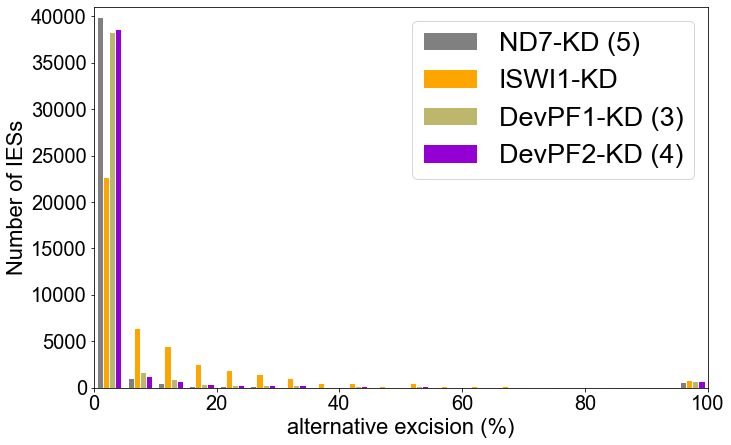

In [8]:
#plot the genome-wide alternative excision distribution (non-cropped)

namesf = ["ND7_5","ISWI1","DevPF1_3","DevPF2_4"]

# retrive fraction data
fractions = []
for na in namesf:
    fraction = df_all[f"{na}_frac"]
    fractions.append(fraction)
    

labels = ['ND7-KD (5)','ISWI1-KD','DevPF1-KD (3)','DevPF2-KD (4)']

plt.figure(figsize=(11,7))
hist(fractions, bins=20, ec='white', log=False, 
     color=['grey','orange','darkkhaki','darkviolet'],
     label=labels)
axis(ymax=41000, xmax=100, xmin=0)
plt.ylabel("Number of IESs", wrap = True, fontsize = 22)
plt.xlabel("alternative excision (%)", wrap = True, fontsize = 22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 27);


plt.savefig("output_files/DevPFs_KD489_alt-ex_Af-Pc_down.pdf", bbox_inches='tight')

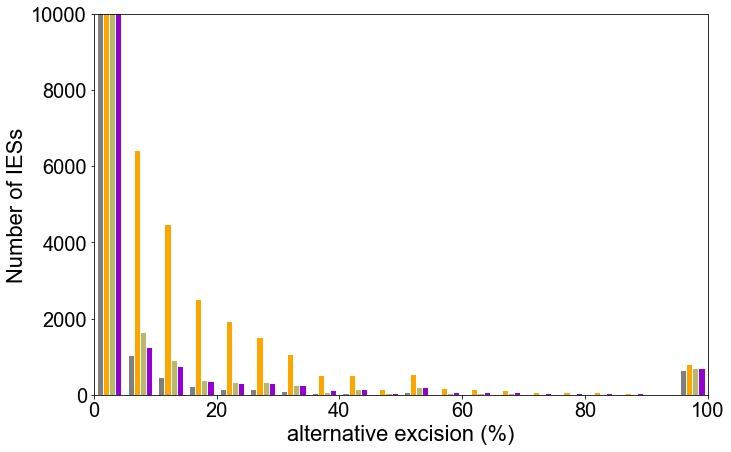

In [6]:
#plot the genome-wide alternative excision distribution (cropped)

plt.figure(figsize=(11,7))
hist(fractions, bins=20, ec='white', log=False, 
     color=['grey','orange','darkkhaki','darkviolet'],
     label=labels)
axis(ymax=10000, xmax=100, xmin=0)
plt.ylabel("Number of IESs", wrap = True, fontsize = 22)
plt.xlabel("alternative excision (%)", wrap = True, fontsize = 22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
#plt.legend(fontsize = 27);


plt.savefig("output_files/DevPFs_KD489_alt-ex_Af-Pc_downS.pdf", bbox_inches='tight')

### Length distribution for alternatively excised IESs

In [4]:
#this script acquires the lengths of alternatively excised IESs

# create data frame with reference IES lengths
df_length = pd.read_csv('IES_length.txt.gz',compression = 'gzip',sep=" ",\
                        header=None, names=['IES_ID','ref_length'])

dfs_len = OrderedDict([(na, []) for na in names_all])
count = int(-1)

#loop through the samples to get subtypes for alternative excision
for fn in fns_all:
    count += 1
    ies_len = {}
    alt_len = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
            
            if kind == 'IES':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                ies_len[ies_id] = len(sequence)
            #for alternatively excised IES store the length of the alternative IES
            elif kind == 'ALTERNATIVE':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                alt_len.setdefault(ies_id, []).append(len(sequence))
                
    # data frame with alternative excised reads lengths for sample
    df_allen = pd.DataFrame.from_dict(alt_len, orient = 'index')
    df_allen = df_allen.reset_index().rename(columns={'index': 'IES_ID'})
    
    # combine to one data frame per sample 
    df_altlen = pd.DataFrame.merge(df_length, df_allen, on='IES_ID', how = 'inner')
    
    # store sample data frame in list
    dfs_len[names_all[count]] = df_altlen


In [5]:
# extract the alternative lengths from the data frames

# Create an empty dictionary to store the extracted values
extracted_values = {}

# get reference values
extracted_values['ref_length'] = df_length['ref_length']

# Iterate over each sample in the dictionary
for sample_name, df in dfs_len.items():
    # Extract values from the dataframe, ignoring the first two columns
    extracted_values[sample_name] = df.iloc[:, 2:].values.flatten().tolist()

    # Remove NaN values from the extracted list
    extracted_values[sample_name] = [x for x in extracted_values[sample_name] if (~np.isnan(x))]

In [7]:
# get statistics for the alternative lengths

table_rows = []

for name, values in extracted_values.items():
    sample = name
    minimum = min(values)
    maxium = max(values)
    
    table_rows.append([name, min(values), max(values), np.mean(values), np.median(values)])
    
table_names = ['sample','min','max', 'mean', 'median']
table2 = pd.DataFrame(table_rows, columns = table_names)
print(table2)
#table2.to_csv("output_files/KD489_min-max_length_alt-ex.csv")

        sample   min     max        mean  median
0   ref_length  20.0  5314.0   79.129274    50.0
1        ND7_a   5.0  9920.0  440.943942    86.0
2        ND7_b   5.0  9144.0  186.968570    74.0
3       AS17_a   5.0  9764.0  344.235116    81.0
4       AS17_b   5.0  9813.0  354.012005    80.0
5       AS17_c   5.0  9897.0  263.043054    77.0
6       AS17_e  12.0  9858.0  330.628169    81.0
7       AS17_f   8.0  9967.0  411.132628    86.0
8       PS17_b   6.0  8448.0  169.056218    63.0
9       PS17_c   6.0  9983.0  313.033927    79.0
10      PS17_d  11.0  9812.0  307.615432    77.0
11         PGM   5.0  8042.0  215.749546    67.0
12       ISWI1   5.0  9892.0  206.192443    73.0


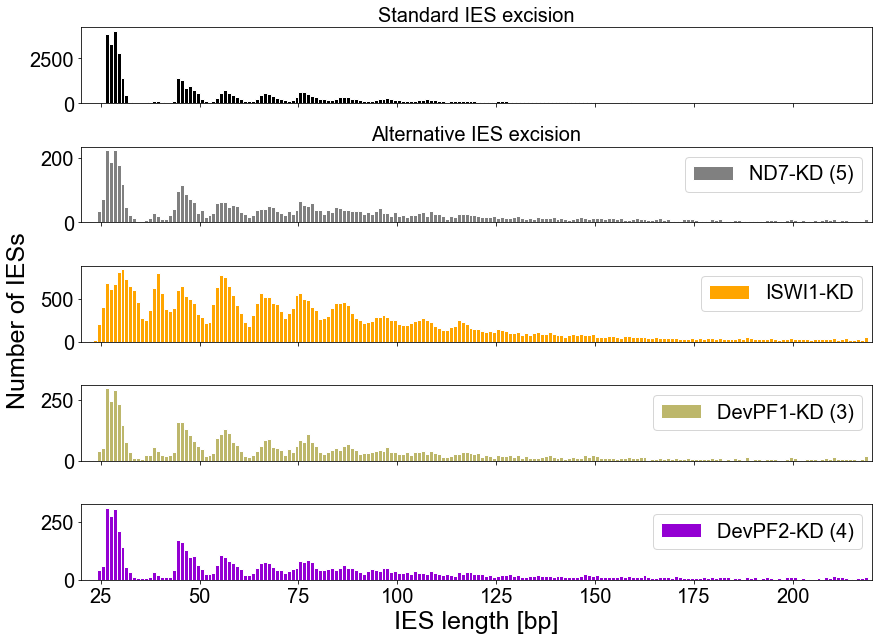

In [9]:
# plot the lengths of alternatively excised IESs

fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(nrows=5, ncols=1, sharex=True, 
                                                                   figsize = (12,9));

ax0.hist(extracted_values['ref_length'], bins=range(20, 220, 1), ec='white', fc='black');
ax1.hist(extracted_values['ND7_5'], bins=range(20, 220, 1), ec='white', fc='grey', 
         label = "ND7-KD (5)");
ax2.hist(extracted_values['ISWI1'], bins=range(20, 220, 1), ec='white', fc='orange', 
         label = "ISWI1-KD");
ax3.hist(extracted_values['DevPF1_3'], bins=range(20, 220, 1), ec='white', fc='darkkhaki', 
         label = "DevPF1-KD (3)");
ax4.hist(extracted_values['DevPF2_4'], bins=range(20, 220, 1), ec='white', fc='darkviolet', 
         label = "DevPF2-KD (4)");



ax1.legend(fontsize=20);
ax2.legend(fontsize=20);
ax3.legend(fontsize=20);
ax4.legend(fontsize=20);

ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)

ax0.set_title("Standard IES excision", fontsize=20)
ax1.set_title("Alternative IES excision", fontsize=20)

ax4.set_xlabel('IES length [bp]', fontsize=25)
ax4.set_xlim([20,220]);

fig.text(0.00001, 0.5, 'Number of IESs', ha='center', va='center', fontsize=25, rotation='vertical');
fig.tight_layout();

fig.savefig("output_files/DevPFs_KD489_alt_length_down_selected.pdf", bbox_inches='tight')

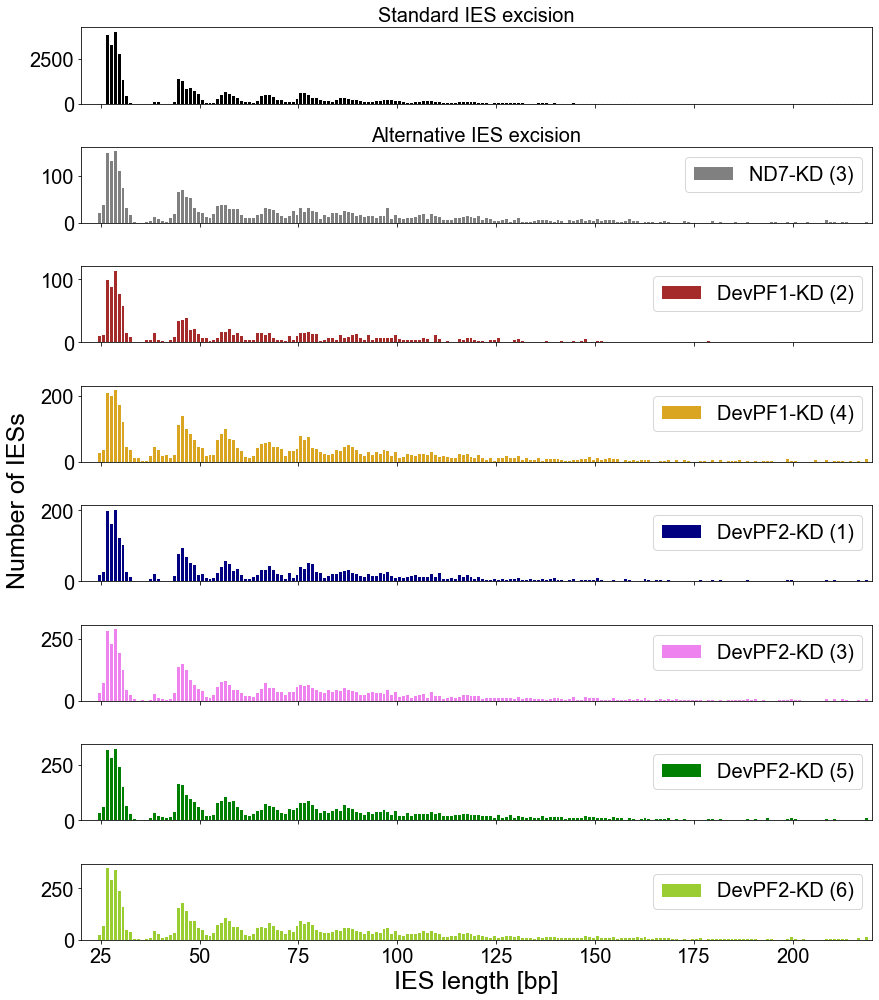

In [10]:
# plot the lengths of alternatively excised IESs

fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(nrows=8, ncols=1, sharex=True, 
                                                                   figsize = (12,14));

ax0.hist(extracted_values['ref_length'], bins=range(20, 220, 1), ec='white', fc='black');
ax1.hist(extracted_values['ND7_3'], bins=range(20, 220, 1), ec='white', fc='grey', 
         label = "ND7-KD (3)");
ax2.hist(extracted_values['DevPF1_2'], bins=range(20, 220, 1), ec='white', fc='brown', 
         label = "DevPF1-KD (2)");
ax3.hist(extracted_values['DevPF1_4'], bins=range(20, 220, 1), ec='white', fc='goldenrod', 
         label = "DevPF1-KD (4)");
ax4.hist(extracted_values['DevPF2_1'], bins=range(20, 220, 1), ec='white', fc='navy', 
         label = "DevPF2-KD (1)");
ax5.hist(extracted_values['DevPF2_3'], bins=range(20, 220, 1), ec='white', fc='violet', 
         label = "DevPF2-KD (3)");
ax6.hist(extracted_values['DevPF2_5'], bins=range(20, 220, 1), ec='white', fc='green', 
         label = "DevPF2-KD (5)");
ax7.hist(extracted_values['DevPF2_6'], bins=range(20, 220, 1), ec='white', fc='yellowgreen', 
         label = "DevPF2-KD (6)");

#ax2.hist(extracted_values['PGM'], bins=range(20, 220, 1), ec='white', fc='lightsteelblue', 
#         label = "PGM-KD");

ax1.legend(fontsize=20);
ax2.legend(fontsize=20);
ax3.legend(fontsize=20);
ax4.legend(fontsize=20);
ax5.legend(fontsize=20);
ax6.legend(fontsize=20);
ax7.legend(fontsize=20);

ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax5.tick_params(axis='both', which='major', labelsize=20)
ax6.tick_params(axis='both', which='major', labelsize=20)
ax7.tick_params(axis='both', which='major', labelsize=20)

ax0.set_title("Standard IES excision", fontsize=20)
ax1.set_title("Alternative IES excision", fontsize=20)

ax7.set_xlabel('IES length [bp]', fontsize=25)
ax7.set_xlim([20,220]);

fig.text(0.00001, 0.5, 'Number of IESs', ha='center', va='center', fontsize=25, rotation='vertical');
fig.tight_layout();

fig.savefig("output_files/DevPFs_KD489_alt_length_down_all.pdf", bbox_inches='tight')